# Effective Hamiltonian Solver for Excitons in Oligomers

In [132]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Parameters for Hamiltonian Matrix

In [133]:
nn_max=3   ## currently enough parameters to include up to nn_max nearest neighbour interactions

ehe=[0.032,0.782,-0.388,0.042]  # <cond|h|cond>, ehe[0] - on-site energy, ehe[r] - transfer integrals r units apart
hhh=[6.515,0.875,-0.177,0.064]  # <val|h|val>, same

J=[9.145,5.360,2.992,1.958]     # direct coulomb terms for different electron-hole distances
K=[2.104,0.383,0.048,0.001]     # exchange coulomb terms 

## Coulomb interaction V=2K-J, for now need to scale J by c1 (Grimme paper), as using DFT not HF energies
V=[]
c1=0.3
for i in range(0,nn_max+1):
   V.append(2*K[i]-c1*J[i])

# transition dipole moments
mu=[[1.080,-0.675,-0.135],          # mux(0) muy(0) muz(0)  # Frenkel exciton
    [-0.847,-0.049,-0.055],         # mux(1) muy(1) muz(1)  # CT excitons for distances up to nn_max
    [0.435,-0.019,-0.022],          # mux(2) muy(2) muz(2)
    [-0.004,-0.018,-0.015]]         # mux(3) muy(3) muz(3)

## Transition energy and dipole moment of monomer (nothing to diagonalise, just one "matrix" element)
E_n1=ehe[0]+hhh[0]+V[0]
mu2_n1=np.sum(np.multiply(mu[0],mu[0]))

### Functions to diagonalise Hamiltonian and return properties

In [134]:
def Heff_solve(n,nn,verbose=0):
    m=1+2*nn   #no. of submatrix elements
    H=np.zeros(shape=(n*m,n*m))
    #loop over matrix elements
    #ij counts rows, i is electron site, j is hole site
    for i in range(0,n):
        for j in range(0,m):
            #rename variable, j is for counting, jj is hole site
            jj=i+j-nn
            #kl counts columns, k is electron site, l is for hole
            for k in range(0,n):
                for l in range(0,m):
                    #rename variable, l is for counting, ll is hole site
                    ll=k+l-nn
                    #matrix indices
                    row=m*i+j
                    col=m*k+l
#                    print(row,col)
                    #distances between particles
                    dist_ee=abs(i-k)
                    dist_hh=abs(jj-ll)
                    dist_eh=abs(i-jj)
#                    print(dist_ee,dist_hh,dist_eh)
                    #electron stationary (same monomer index)
                    if i==k:
                        #hole stationary (distance is zero, also same monomer index)
                        if dist_hh==0:
                            #Frenkel or CT exciton energy (e and h dist_eh apart)
                            H[row][col]=ehe[0]+hhh[0]+V[dist_eh]
                        #electron still stationary, hole jumps to (near) neighbour
                        elif dist_hh<=nn:
                            H[row][col]=hhh[dist_hh]
                    #electron jumps to (near) neighbour
                    elif dist_ee<=nn:
                        #but only get coupling if hole is stationary
                         if dist_hh==0:
                                H[row][col]=ehe[dist_ee]
                    #Remove PBCs by zeroing terms that would appear only in PBC case
                    if jj<0 or jj>n-1 or ll<0 or ll>n-1:
                        H[row][col]=0       
    #Matrix full, now diagonalise
    Hmat=np.matrix(H)
    vals, vecs = np.linalg.eig(H)
    #order eigenvalues and eigenvectors from highest to lowest transition energy
    idx = vals.argsort()[::-1] 
    vals = vals[idx]
    vecs = vecs[:,idx]
    if verbose==1:
        print(Hmat)
        print(vals)
    return vals,vecs

#return transition energy and dipole moment of given state
def calc_mu_dE(n,nn,state,vals,vecs,verbose):
    m=1+2*nn       #no. of submatrix elements
    mu_n=[0,0,0]   #zero tdm for n-mer
#    if verbose==1:
#        print("Using this eigenvector:")
#        print(vecs[:,state])
    for i in range(0,n):  #loop over electron sites
        for j in range(0,m):
            #rename variable, j is for counting, jj is hole site
            jj=i+j-nn
            #row index to get correct eigenvecotr element
            row=m*i+j
            #electron-hole distance to get correct tdm from parameters
            dist_eh=abs(i-jj)
            mu_n[0] += vecs[row,state]*mu[dist_eh][0]   #x component
            mu_n[1] += vecs[row,state]*mu[dist_eh][1]   #y component
            mu_n[2] += vecs[row,state]*mu[dist_eh][2]   #z component
    if verbose==1:
        print("n={n}, state={state}, E={e}, mu2_perN={mu2}".format(n=n,state=state,e=vals[state],mu2=np.sum(np.multiply(mu_n,mu_n))/n))
    return mu_n,vals[state]

### Calculate some properties for polyacetylene
Can change the parameters in the top box to play around with the model and see how increasing nn changes results for different oligomer lengths up to nmax

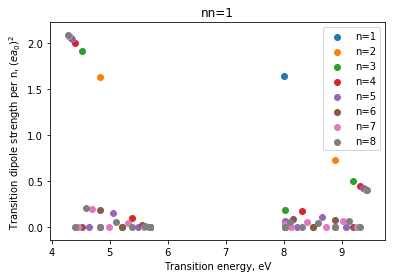

In [135]:
##############
# Parameters #
##############
nmax=8       # use oligomers up to nmax units long
verbose=0    # set to 1 to print out results in addition to plotting them
nn=1         # no. of nearest neighbours interacting
##############

if nn > nn_max:
    print("ERROR! Only have enough parameters to use nn up to {nn_max}".format(**locals()))
m=2*nn+1           # no. submatrix elements
E=[E_n1]           # lists for transition energies and TDM squared for plotting
mu2_pern=[mu2_n1]  

#calculate energy and TDM for each oligomer length n
for n in np.arange(2,nmax+1):
    E_n=[]    
    mu2_pern_n=[]
    vals,vecs=Heff_solve(n,nn)
    for state in np.arange(0,n*m):
        #get energy and tdm of each state
        mu_n_state,E_n_state=calc_mu_dE(n,nn,state,vals,vecs,verbose)
        #some E are zero, due to considering finite chains (no PBCs), they're meaningless
        if E_n_state != 0:
            E_n.append(E_n_state)
            #mostly interested in square of TDM per n
            mu2_pern_n.append(np.divide(np.sum(np.multiply(mu_n_state,mu_n_state)),n))
    E.append(E_n)
    mu2_pern.append(mu2_pern_n)

# Plot all excitations to get overview
for i in range(1,nmax+1):
    plt.scatter(E[i-1],mu2_pern[i-1],label="n={n}".format(n=i))
plt.title("nn={nn}".format(nn=nn))
plt.xlabel("Transition energy, eV")
plt.ylabel("Transition dipole strength per n, $(ea_0)^2$")
plt.legend()
plt.savefig("oligoacet_nmax{nmax}_nn{nn}_allTransitions".format(**locals()))

After verifying that for these parameters the brightest (highest dipole strength) excitation is for the lowest energy, plotting what I'm really after - the relationship of energy and dipole strength per monomer as a function of oligomer length for the lowest energy (first) transition

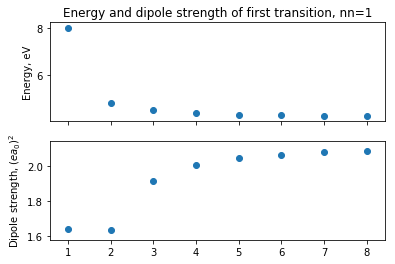

In [136]:
#Will plot transiiton energy E_low and dipole strength per monomer mu2_pern_low for all oligomer lengths N
N=np.arange(1,nmax+1)
E_low=[E[0]]                   #first element in list is just a number, not a list
mu2_pern_low=[mu2_pern[0]]
for i in range(1,nmax):
    E_low.append(E[i][-1])     #want lowest energy, so last element (sorted eigenvals in decreasing order)
    mu2_pern_low.append(mu2_pern[i][-1])

f, axarr = plt.subplots(2, sharex=True)
axarr[0].scatter(N,E_low)
axarr[1].scatter(N,mu2_pern_low)
axarr[0].set_title('Energy and dipole strength of first transition, nn={nn}'.format(**locals()))
axarr[0].set_ylabel("Energy, eV")
axarr[1].set_ylabel("Dipole strength, $(ea_0)^2$")
plt.savefig("oligoacet_nmax{nmax}_nn{nn}_lowestTransition".format(**locals()))